In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data_task1.csv',encoding = 'gbk')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4752 entries, 0 to 4751
Data columns (total 81 columns):
Unnamed: 0                                    4752 non-null int64
regional_mobility                             4752 non-null float64
is_high_user                                  4752 non-null int64
avg_consume_less_12_valid_month               4752 non-null float64
reg_preference_for_trad                       4752 non-null float64
status                                        4752 non-null int64
low_volume_percent                            4752 non-null float64
middle_volume_percent                         4752 non-null float64
take_amount_in_later_12_month_highest         4752 non-null float64
trans_amount_increase_rate_lately             4752 non-null float64
trans_activity_month                          4752 non-null float64
trans_activity_day                            4752 non-null float64
transd_mcc                                    4752 non-null float64
trans_days_inte

In [4]:
df = df.iloc[:,1:]
df.head()

,regional_mobility,is_high_user,avg_consume_less_12_valid_month,reg_preference_for_trad,status,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,...,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,first_transaction_day_re,active_day
0,3.0,0,7.0,0.0,1,0.01,0.99,0.0,0.90,0.55,...,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,1724.0,12.0
1,4.0,0,5.0,0.0,0,0.02,0.94,2000.0,1.28,1.00,...,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,765.0,2.0
2,1.0,0,5.0,0.0,1,0.04,0.96,0.0,1.00,1.00,...,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,324.0,2.0
3,3.0,0,7.0,1.0,0,0.00,0.96,2000.0,0.13,0.57,...,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,1817.0,2.0
4,1.0,0,6.0,0.0,1,0.01,0.99,0.0,0.46,1.00,...,1630.0,8300.0,79.0,2.0,2.0,8400.0,8250.0,22.0,421.0,22.0


In [5]:
y = df['status']
X = df.drop(columns = ['status'],axis = 1)

## 计算IV值

In [6]:
import math
from scipy import stats
from sklearn.utils.multiclass import type_of_target

def woe(X, y, event=1):  
    res_woe = []
    iv_dict = {}
    for feature in X.columns:
        x = X[feature].values
        # 1) 连续特征离散化
        if type_of_target(x) == 'continuous':
            x = discrete(x)
        # 2) 计算该特征的woe和iv
        # woe_dict, iv = woe_single_x(x, y, feature, event)
        woe_dict, iv = woe_single_x(x, y, feature, event)
        iv_dict[feature] = iv
        res_woe.append(woe_dict) 
        
    return iv_dict
def discrete(x):
    # 使用5等分离散化特征
    res = np.zeros(x.shape)
    for i in range(5):
        #stats.scoreatpercentile([1,2,3,4,5],50)    # 计算输入序列中给定百分位数的分数 返回值是3
        point1 = stats.scoreatpercentile(x, i * 20)
        point2 = stats.scoreatpercentile(x, (i + 1) * 20)
        x1 = x[np.where((x >= point1) & (x <= point2))]  #将x分到[0,20],[20,40],[40,60],[60,80],[80,100]5个区间进行离散化
        mask = np.in1d(x, x1) #测试一维数组的每个元素是否也存在于第二个数组中
        res[mask] = i + 1    # 将[i, i+1]块内的值标记成i+1
    return res
def woe_single_x(x, y, feature,event = 1):
    # event代表预测正例的标签
    event_total = (y == event).sum()  #预测为正例的数量
    non_event_total = y.shape[-1] - event_total #预测为负例的数量
    
    iv = 0
    woe_dict = {}
    for x1 in set(x):    # 遍历各个特征标签
        y1 = y.reindex(np.where(x == x1)[0])
        event_count = sum(y1 == event)  
        non_event_count = y1.shape[-1] - event_count
        
        rate_event = event_count / event_total  
        rate_non_event = non_event_count / non_event_total
        
        if rate_event == 0:
            rate_event = 0.0001
            # woei = -20
        elif rate_non_event == 0:
            rate_non_event = 0.0001
            # woei = 20
        woei = math.log(rate_event / rate_non_event) #表示第i组中正例/负例比值
        woe_dict[x1] = woei
        iv += (rate_event - rate_non_event) * woei
    return woe_dict, iv

In [7]:
iv_dict = woe(X,y)
iv = pd.DataFrame(sorted(iv_dict.items(), key = lambda x:x[1],reverse = True),columns=['Var','Iv'])
iv

,Var,Iv
0,historical_trans_amount,2.497334
1,trans_amount_3_month,2.324892
2,pawns_auctions_trusts_consume_last_6_month,1.973832
3,repayment_capability,1.947715
4,first_transaction_day_re,1.648852
5,abs,1.438627
6,consfin_avg_limit,1.384010
7,consume_mini_time_last_1_month,1.120906
8,loans_avg_limit,0.909205
9,max_cumulative_consume_later_1_month,0.899189


In [8]:
#IV值的取值范围是[0,正无穷]，<0.02,无用，0.02-0.1弱预测，0.1-0.3中等预测，0.3-0.5强预测;>0.5可疑
threshold1 = 0.02
#threshold2 = 0.5 #实际工作上感觉基本不对这个设限
data_index = []
for i in range(len(iv)):
    #if ((iv['Iv'][i]<threshold1)|(iv['Iv'][i]>threshold2)):
    if(iv['Iv'][i]<threshold1):
        data_index.append(iv['Var'][i])
X.drop(data_index,axis=1,inplace=True)

In [9]:
X.shape

(4752, 67)

In [10]:
X.columns

Index(['take_amount_in_later_12_month_highest',
       'trans_amount_increase_rate_lately', 'transd_mcc',
       'trans_days_interval_filter', 'trans_days_interval',
       'repayment_capability', 'number_of_trans_from_2011',
       'historical_trans_amount', 'historical_trans_day', 'rank_trad_1_month',
       'trans_amount_3_month', 'abs', 'top_trans_count_last_1_month',
       'avg_price_last_12_month', 'avg_price_top_last_12_valid_month',
       'trans_top_time_last_1_month', 'trans_top_time_last_6_month',
       'consume_top_time_last_1_month', 'consume_top_time_last_6_month',
       'cross_consume_count_last_1_month',
       'trans_fail_top_count_enum_last_1_month',
       'trans_fail_top_count_enum_last_6_month',
       'trans_fail_top_count_enum_last_12_month',
       'consume_mini_time_last_1_month',
       'max_cumulative_consume_later_1_month',
       'max_consume_count_later_6_month',
       'pawns_auctions_trusts_consume_last_1_month',
       'pawns_auctions_trusts_consume_

## 利用随机森林挑选特征值

In [11]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X, y)
rfc_impc = pd.Series(rfc.feature_importances_, index = X.columns).sort_values(ascending=False)
fea_gini = rfc_impc[:20].index
fea_gini

Index(['history_fail_fee', 'trans_fail_top_count_enum_last_1_month',
       'apply_score', 'loans_score', 'latest_one_month_fail',
       'repayment_capability', 'abs', 'first_transaction_day_re',
       'avg_price_last_12_month', 'trans_day_last_12_month',
       'max_cumulative_consume_later_1_month', 'query_org_count',
       'trans_amount_3_month', 'historical_trans_amount', 'consfin_avg_limit',
       'latest_query_day', 'active_day', 'loans_avg_limit',
       'trans_fail_top_count_enum_last_6_month', 'trans_days_interval_filter'],
      dtype='object')

In [12]:
finalX = X.loc[:,fea_gini]
finalX.shape

(4752, 20)

In [13]:
y[y==1].count()/y[y==0].count()

0.3352065186850239

## 消除量纲

In [14]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(finalX)

## 跑下看看结果

In [15]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=2018)
from sklearn.linear_model import LogisticRegression as LR
lr = LR().fit(Xtrain,Ytrain)
#lr.score(Xtest,Ytest)
from sklearn import metrics
Ytest_pred = lr.predict(Xtest)
acc = metrics.accuracy_score(Ytest,Ytest_pred)
precision = metrics.precision_score(Ytest,Ytest_pred)
recall = metrics.recall_score(Ytest,Ytest_pred)
f1 = metrics.f1_score(Ytest,Ytest_pred)
auc= metrics.roc_auc_score(Ytest,Ytest_pred)
print('准确率:{:.4f},精确率:{:.4f},召回率:{:.4f},f1-score:{:.4f},auc:{:.4f}'.format(acc,precision,recall,f1,auc))

准确率:0.7924,精确率:0.6603,召回率:0.2977,f1-score:0.4104,auc:0.6243


In [16]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(Xtrain,Ytrain)
rfc.score(Xtest,Ytest)

0.788218793828892

In [17]:
from sklearn import metrics
Ytest_pred = rfc.predict(Xtest)
acc = metrics.accuracy_score(Ytest,Ytest_pred)
precision = metrics.precision_score(Ytest,Ytest_pred)
recall = metrics.recall_score(Ytest,Ytest_pred)
f1 = metrics.f1_score(Ytest,Ytest_pred)
auc= metrics.roc_auc_score(Ytest,Ytest_pred)
print('准确率:{:.4f},精确率:{:.4f},召回率:{:.4f},f1-score:{:.4f},auc:{:.4f}'.format(acc,precision,recall,f1,auc))

准确率:0.7882,精确率:0.6170,召回率:0.3353,f1-score:0.4345,auc:0.6343


In [18]:
from xgboost import XGBClassifier as XGBC
clf = XGBC().fit(Xtrain,Ytrain)
clf.score(Xtest,Ytest)

0.800140252454418

In [19]:
from sklearn import metrics
Ytest_pred = clf.predict(Xtest)
acc = metrics.accuracy_score(Ytest,Ytest_pred)
precision = metrics.precision_score(Ytest,Ytest_pred)
recall = metrics.recall_score(Ytest,Ytest_pred)
f1 = metrics.f1_score(Ytest,Ytest_pred)
auc= metrics.roc_auc_score(Ytest,Ytest_pred)
print('准确率:{:.4f},精确率:{:.4f},召回率:{:.4f},f1-score:{:.4f},auc:{:.4f}'.format(acc,precision,recall,f1,auc))

准确率:0.8001,精确率:0.6564,召回率:0.3699,f1-score:0.4732,auc:0.6540


## 处理样本不平衡

In [20]:
import imblearn
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=420)
X,y = sm.fit_sample(finalX,y)

In [21]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

## 逻辑回归

In [22]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=2018)
from sklearn.linear_model import LogisticRegression as LR
lr = LR().fit(Xtrain,Ytrain)
#lr.score(Xtest,Ytest)
from sklearn import metrics
Ytest_pred = lr.predict(Xtest)
acc = metrics.accuracy_score(Ytest,Ytest_pred)
precision = metrics.precision_score(Ytest,Ytest_pred)
recall = metrics.recall_score(Ytest,Ytest_pred)
f1 = metrics.f1_score(Ytest,Ytest_pred)
auc= metrics.roc_auc_score(Ytest,Ytest_pred)
print('准确率:{:.4f},精确率:{:.4f},召回率:{:.4f},f1-score:{:.4f},auc:{:.4f}'.format(acc,precision,recall,f1,auc))

准确率:0.7144,精确率:0.7266,召回率:0.6771,f1-score:0.7010,auc:0.7140


## SVM

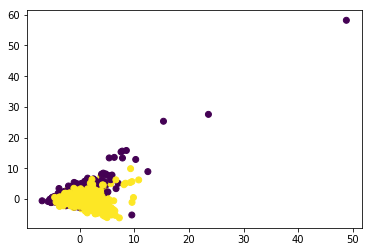

In [32]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
X_dr = PCA(2).fit_transform(X)
plt.scatter(X_dr[:,0],X_dr[:,1],c=y)  #20个特征降维进行可视化
plt.show()

In [25]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf',gamma='auto',cache_size=5000).fit(Xtrain,Ytrain)
clf.score(Xtest,Ytest)

0.7607677902621723

## 决策树

In [26]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier().fit(Xtrain,Ytrain)
dtc.score(Xtest,Ytest)

0.7771535580524345

In [27]:
from sklearn import metrics
Ytest_pred = dtc.predict(Xtest)
acc = metrics.accuracy_score(Ytest,Ytest_pred)
precision = metrics.precision_score(Ytest,Ytest_pred)
recall = metrics.recall_score(Ytest,Ytest_pred)
f1 = metrics.f1_score(Ytest,Ytest_pred)
auc= metrics.roc_auc_score(Ytest,Ytest_pred)
print('准确率:{:.4f},精确率:{:.4f},召回率:{:.4f},f1-score:{:.4f},auc:{:.4f}'.format(acc,precision,recall,f1,auc))

准确率:0.7772,精确率:0.7690,召回率:0.7850,f1-score:0.7769,auc:0.7772


## 随机森林

In [28]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(Xtrain,Ytrain)
rfc.score(Xtest,Ytest)

0.8249063670411985

In [29]:
from sklearn import metrics

Ytest_pred = rfc.predict(Xtest)
acc = metrics.accuracy_score(Ytest,Ytest_pred)
precision = metrics.precision_score(Ytest,Ytest_pred)
recall = metrics.recall_score(Ytest,Ytest_pred)
f1 = metrics.f1_score(Ytest,Ytest_pred)
auc= metrics.roc_auc_score(Ytest,Ytest_pred)
print('准确率:{:.4f},精确率:{:.4f},召回率:{:.4f},f1-score:{:.4f},auc:{:.4f}'.format(acc,precision,recall,f1,auc))

准确率:0.8249,精确率:0.8545,召回率:0.7784,f1-score:0.8147,auc:0.8244


## XGBoost 

In [30]:
from xgboost import XGBClassifier as XGBC
clf = XGBC().fit(Xtrain,Ytrain)
clf.score(Xtest,Ytest)

0.8352059925093633

In [31]:
from sklearn import metrics
Ytest_pred = clf.predict(Xtest)
acc = metrics.accuracy_score(Ytest,Ytest_pred)
precision = metrics.precision_score(Ytest,Ytest_pred)
recall = metrics.recall_score(Ytest,Ytest_pred)
f1 = metrics.f1_score(Ytest,Ytest_pred)
auc= metrics.roc_auc_score(Ytest,Ytest_pred)
print('准确率:{:.4f},精确率:{:.4f},召回率:{:.4f},f1-score:{:.4f},auc:{:.4f}'.format(acc,precision,recall,f1,auc))

准确率:0.8352,精确率:0.8438,召回率:0.8182,f1-score:0.8308,auc:0.8350
